## Phase 1

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, floor, asin

def hadamard_state(n):
    N = 2**n
    return np.ones(N, dtype=complex)/np.sqrt(N)

def oracle_matrix(n, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n):
    N = 2**n
    psi = np.ones((N, N), dtype=complex)/N
    return 2*psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U.dot(state)

def measure_state(state, shots=1024):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[marked_indices])**2))

def run_sampling_adaptive(n, marked_index, max_iterations=10, est_shots=100, target_prob=0.9, patience=2, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)
    best_est = 0.0
    no_improve = 0
    est_checks = 0
    iterations_used = 0
    est_hist = []

    for i in range(max_iterations):
        state = apply_operator(state, O)
        state = apply_operator(state, D)
        iterations_used += 1

        samples = measure_state(state, shots=est_shots)
        est_checks += 1
        est_p = np.mean([1 if s == marked_index else 0 for s in samples])
        est_hist.append(est_p)

        if est_p > best_est + 1e-12:
            best_est = est_p
            no_improve = 0
        else:
            no_improve += 1

        if est_p >= target_prob or no_improve >= patience:
            break

    return {
        "final_state": state,
        "final_prob": success_probability(state, [marked_index]),
        "iterations_used": iterations_used,
        "est_checks": est_checks,
        "est_history": est_hist
    }

def phase1_experiment(n=4, trials=300, est_shots=100, target_prob=0.9, patience=2, seed=42):
    rng = np.random.default_rng(seed)
    N = 2**n
    results = []
    for t in range(trials):
        marked = rng.integers(0, N)
        out = run_sampling_adaptive(n, marked, max_iterations=10, est_shots=est_shots,
                                    target_prob=target_prob, patience=patience, rng=rng)
        results.append(out)
    final_probs = np.array([r["final_prob"] for r in results])
    iters = np.array([r["iterations_used"] for r in results])
    shots_total = np.array([r["est_checks"]*est_shots for r in results])
    summary = {
        "N": N,
        "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_iterations": float(iters.mean()),
        "std_iterations": float(iters.std()),
        "mean_total_shots": float(shots_total.mean()),
        "std_total_shots": float(shots_total.std())
    }
    return results, summary

results, summary = phase1_experiment(n=4, trials=300, est_shots=100, target_prob=0.9, patience=2, seed=42)
summary


{'N': 16,
 'trials': 300,
 'mean_final_prob': 0.923219633102417,
 'std_final_prob': 0.031245360006513085,
 'mean_iterations': 2.3066666666666666,
 'std_iterations': 0.4682829154356252,
 'mean_total_shots': 230.66666666666666,
 'std_total_shots': 46.82829154356252}

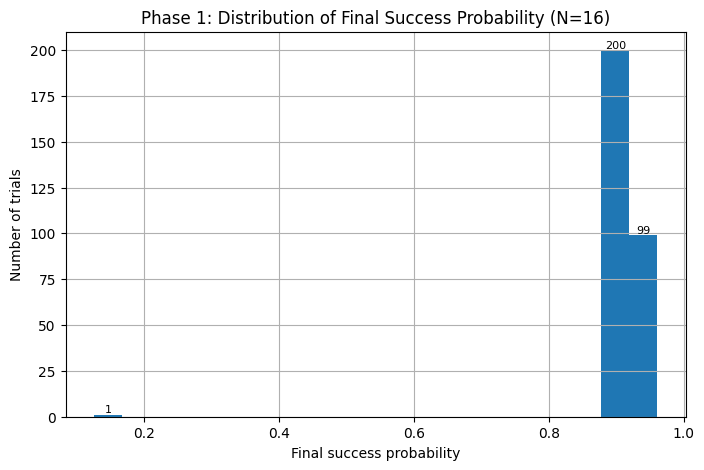

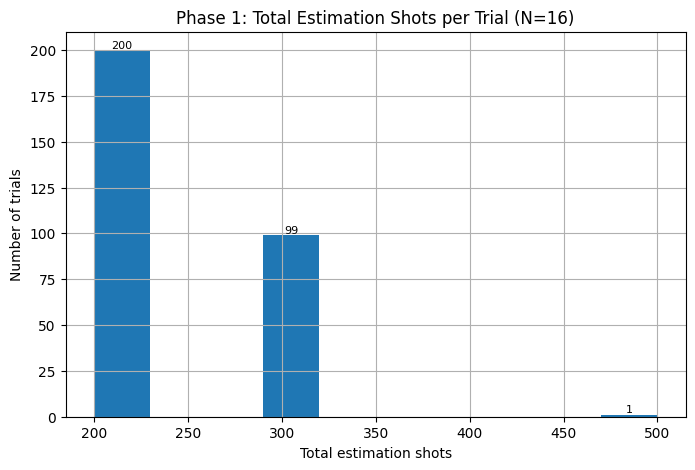

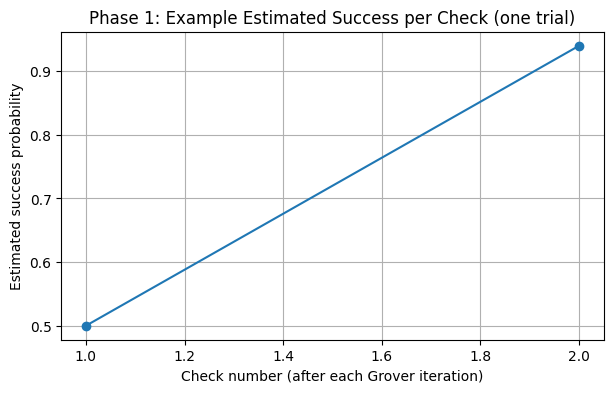

In [ ]:
# Show the summary nicely and create a few simple plots for Phase 1
import pandas as pd

df_summary = pd.DataFrame([summary])
df_summary

# Histogram of final success probabilities
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
vals = [r["final_prob"] for r in results]
hist, bins, _ = plt.hist(vals, bins=20)
plt.title("Phase 1: Distribution of Final Success Probability (N=16)")
plt.xlabel("Final success probability")
plt.ylabel("Number of trials")
plt.grid(True)

# Add text labels above the bars
for i in range(len(hist)):
    if hist[i] > 0:
        plt.text(bins[i] + (bins[i+1]-bins[i])/2, hist[i], int(hist[i]), ha='center', va='bottom', fontsize=8)

plt.show()

# Histogram of total estimation shots
plt.figure(figsize=(8,5))
shots = [r["est_checks"]*100 for r in results]
hist_shots, bins_shots, _ = plt.hist(shots, bins=10)
plt.title("Phase 1: Total Estimation Shots per Trial (N=16)")
plt.xlabel("Total estimation shots")
plt.ylabel("Number of trials")
plt.grid(True)

# Add text labels above the bars for shots histogram
for i in range(len(hist_shots)):
    if hist_shots[i] > 0:
        plt.text(bins_shots[i] + (bins_shots[i+1]-bins_shots[i])/2, hist_shots[i], int(hist_shots[i]), ha='center', va='bottom', fontsize=8)

plt.show()

# Example convergence trace for one trial
example = results[0]["est_history"]
plt.figure(figsize=(7,4))
plt.plot(range(1, len(example)+1), example, marker='o')
plt.title("Phase 1: Example Estimated Success per Check (one trial)")
plt.xlabel("Check number (after each Grover iteration)")
plt.ylabel("Estimated success probability")
plt.grid(True)
plt.show()

## Phase 2


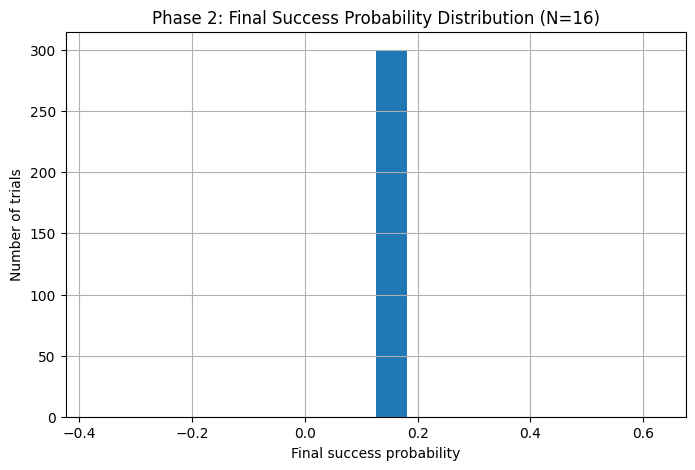

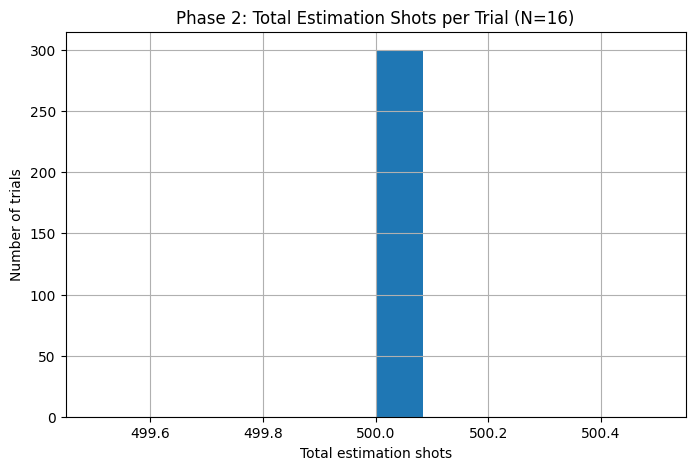

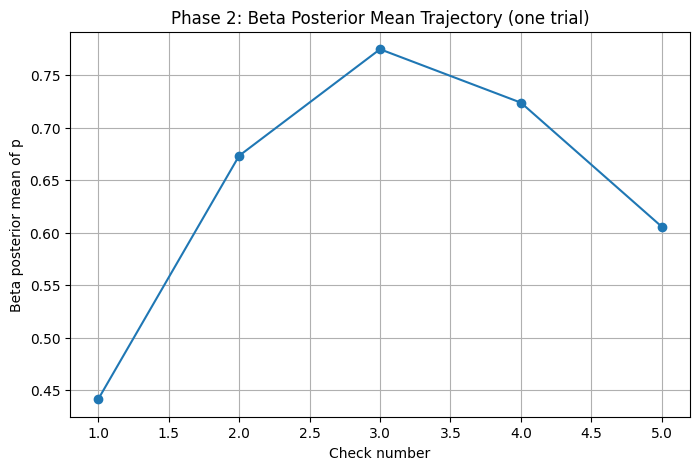

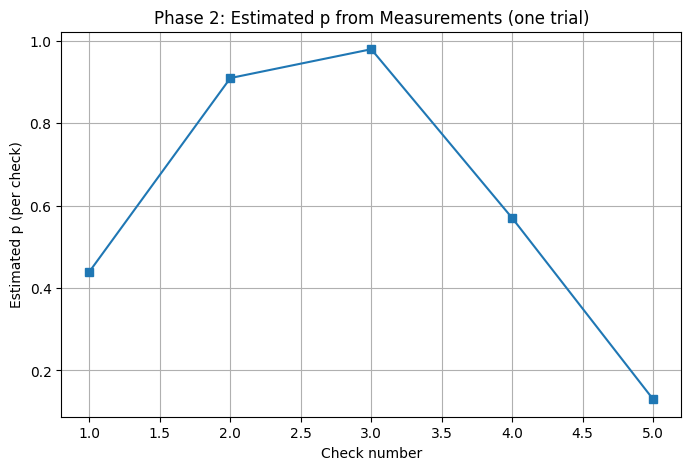

In [6]:
# Re-run Phase 2 after environment reset

import numpy as np
import matplotlib.pyplot as plt
from math import asin, pi
import pandas as pd

np.random.seed(101)

def hadamard_state(n):
    N = 2**n
    return np.ones(N, dtype=complex)/np.sqrt(N)

def oracle_matrix(n, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n):
    N = 2**n
    psi = np.ones((N, N), dtype=complex)/N
    return 2*psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U.dot(state)

def measure_state(state, shots=1024):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[marked_indices])**2))

def run_beta_bayes(n, marked_index, max_iterations=10, est_shots=100, target_prob=0.9, patience=2):
    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)

    a, b = 1.0, 1.0  # Beta(1,1)
    best_mean = 0.0
    no_improve = 0
    est_checks = 0
    iterations_used = 0

    beta_mean_hist = []
    est_hist = []

    for i in range(max_iterations):
        state = apply_operator(state, O); state = apply_operator(state, D)
        iterations_used += 1
        samples = measure_state(state, shots=est_shots)
        s = int(np.sum(samples == marked_index)); f = est_shots - s
        est_p = s / est_shots; est_hist.append(est_p)
        a += s; b += f
        beta_mean = a / (a + b); beta_mean_hist.append(beta_mean)
        est_checks += 1
        if beta_mean > best_mean + 1e-12:
            best_mean = beta_mean; no_improve = 0
        else:
            no_improve += 1
        if beta_mean >= target_prob or no_improve >= patience:
            break

    return {
        "final_state": state,
        "final_prob": success_probability(state, [marked_index]),
        "iterations_used": iterations_used,
        "est_checks": est_checks,
        "beta_mean_hist": beta_mean_hist,
        "est_hist": est_hist
    }

def phase2_experiment(n=4, trials=300, est_shots=100, target_prob=0.9, patience=2, seed=21):
    rng = np.random.default_rng(seed)
    N = 2**n
    outs = []
    for _ in range(trials):
        marked = rng.integers(0, N)
        res = run_beta_bayes(n, marked, max_iterations=10, est_shots=est_shots, target_prob=target_prob, patience=patience)
        outs.append(res)
    final_probs = np.array([o["final_prob"] for o in outs])
    iters = np.array([o["iterations_used"] for o in outs])
    shots_total = np.array([o["est_checks"]*est_shots for o in outs])
    summary = {
        "N": N, "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_iterations": float(iters.mean()),
        "std_iterations": float(iters.std()),
        "mean_total_shots": float(shots_total.mean()),
        "std_total_shots": float(shots_total.std())
    }
    return outs, summary

outs2, summary2 = phase2_experiment(n=4, trials=300, est_shots=100, target_prob=0.9, patience=2, seed=21)
pd.DataFrame([summary2]) # Changed from display_dataframe_to_user to direct display

# Plots
plt.figure(figsize=(8,5))
plt.hist([o["final_prob"] for o in outs2], bins=18)
plt.title("Phase 2: Final Success Probability Distribution (N=16)")
plt.xlabel("Final success probability"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.hist([o["est_checks"]*100 for o in outs2], bins=12)
plt.title("Phase 2: Total Estimation Shots per Trial (N=16)")
plt.xlabel("Total estimation shots"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

ex = outs2[0]
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["beta_mean_hist"])+1), ex["beta_mean_hist"], marker='o')
plt.title("Phase 2: Beta Posterior Mean Trajectory (one trial)")
plt.xlabel("Check number"); plt.ylabel("Beta posterior mean of p")
plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["est_hist"])+1), ex["est_hist"], marker='s')
plt.title("Phase 2: Estimated p from Measurements (one trial)")
plt.xlabel("Check number"); plt.ylabel("Estimated p (per check)")
plt.grid(True); plt.show()


## Phase 3

Phase 3 — EI on p (N=16) summary:
N: 16
trials: 300
mean_final_prob: 0.9613189697265625
std_final_prob: 0.0
mean_iterations: 3.0
std_iterations: 0.0
mean_total_shots: 300.0
std_total_shots: 0.0


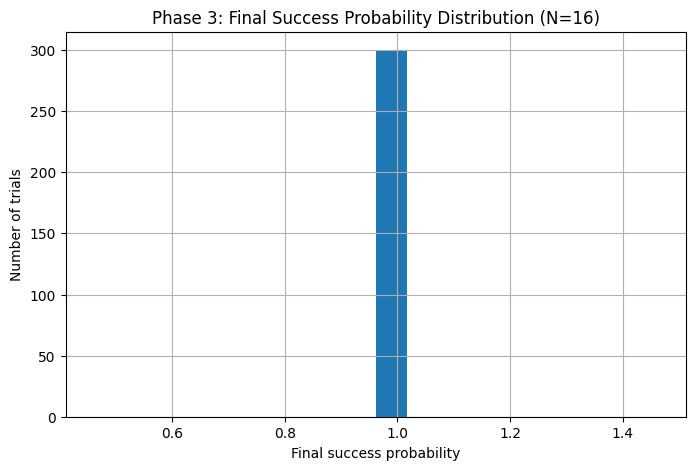

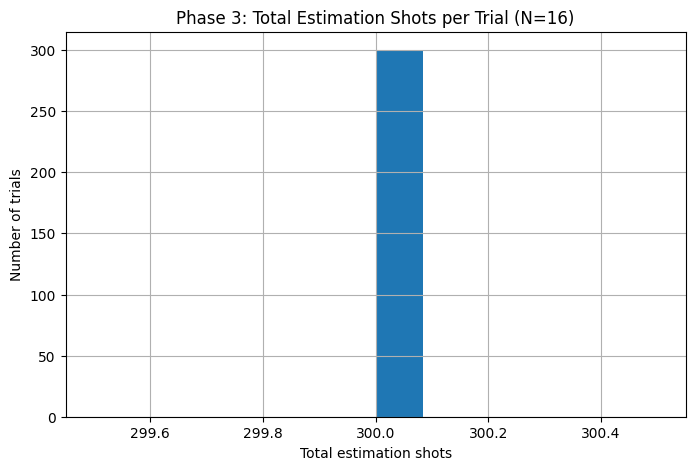

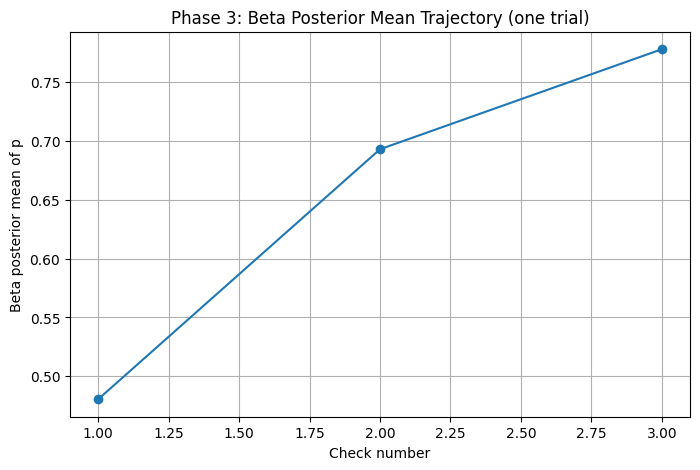

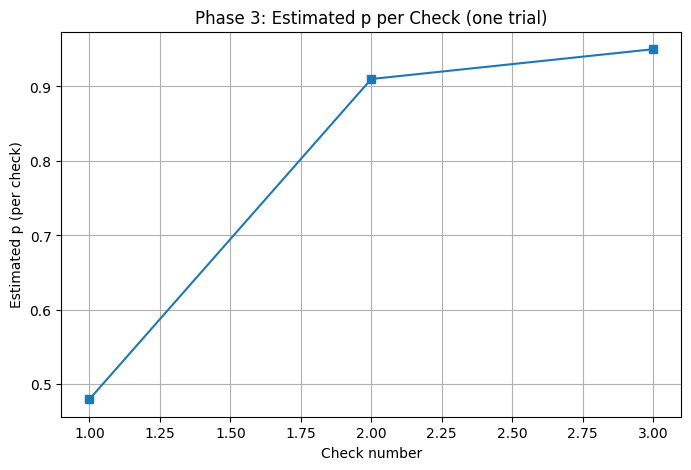

In [7]:


import numpy as np
import matplotlib.pyplot as plt
from math import asin, pi
from dataclasses import dataclass

# ---------- Utilities ----------
def set_seed(seed: int = 123):
    np.random.seed(seed)

def hadamard_state(n: int):
    N = 2**n
    return np.ones(N, dtype=complex) / np.sqrt(N)

def oracle_matrix(n: int, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n: int):
    N = 2**n
    psi = np.ones((N, N), dtype=complex) / N
    return 2 * psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U @ state

def measure_state(state, shots: int):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[list(marked_indices)])**2))

# ---------- Phase 3 controller (EI on p) ----------
@dataclass
class Phase3Config:
    n: int = 4                 # qubits => N=16 default
    max_iterations: int = 10
    est_shots: int = 100       # shots per check
    p_target: float = 0.90     # target success
    patience: int = 2          # early stop if EI <= 0 repeatedly
    smooth_alpha: float = 0.5  # smoothing of p estimates in surrogate
    seed: int = 7

def expected_improvement_on_p(p_hist, alpha=0.5):
    """
    Build a local surrogate for p_{t+1} from the last two estimates.
    - Smooth last two p's to reduce noise: p^s_t = alpha*p_t + (1-alpha)*p_{t-1}
    - Extrapolate one step: p_hat_{t+1} = p^s_t + (p^s_t - p^s_{t-1})
      (i.e., linear trend extrapolation; this is intentionally naive)
    EI = max(p_hat_{t+1} - p_t, 0)
    Returns EI (scalar) and the extrapolated p_hat_{t+1}.
    """
    if len(p_hist) < 2:
        return np.inf, None  # need at least 2 points to form a trend; force continue
    p_tm1 = p_hist[-2]
    p_t   = p_hist[-1]
    # simple exponential smoothing for both
    ps_tm1 = p_tm1  # with two points, smoothing reduces to identity for tm1
    ps_t   = alpha * p_t + (1 - alpha) * p_tm1
    # linear extrapolation of smoothed series
    p_hat_next = ps_t + (ps_t - ps_tm1)
    ei = max(p_hat_next - p_t, 0.0)
    return ei, p_hat_next

def run_phase3_trial(cfg: Phase3Config, rng=None):
    if rng is None:
        rng = np.random.default_rng(cfg.seed)

    N = 2**cfg.n
    marked = {int(rng.integers(0, N))}

    O = oracle_matrix(cfg.n, marked)
    D = diffusion_matrix(cfg.n)
    state = hadamard_state(cfg.n)

    # Beta(1,1) prior on p (this is the naive choice)
    a, b = 1.0, 1.0

    p_est_hist = []        # per-check empirical p estimates
    beta_mean_hist = []    # posterior means (a/(a+b))
    iterations_used = 0
    checks = 0
    no_improve = 0

    for it in range(cfg.max_iterations):
        # one Grover iteration
        state = apply_operator(state, O)
        state = apply_operator(state, D)
        iterations_used += 1

        # measurement to estimate current p_t
        samples = measure_state(state, shots=cfg.est_shots)
        s = int(np.sum([1 if s0 in marked else 0 for s0 in samples]))
        f = cfg.est_shots - s
        p_hat = s / cfg.est_shots
        p_est_hist.append(p_hat)

        # Beta update (naively accumulates across t — the flaw)
        a += s
        b += f
        beta_mean = a / (a + b)
        beta_mean_hist.append(beta_mean)
        checks += 1

        # Expected improvement (naive, on p)
        ei, p_hat_next = expected_improvement_on_p(p_est_hist, alpha=cfg.smooth_alpha)

        # stopping: hit target or EI not positive repeatedly
        if beta_mean >= cfg.p_target:
            break

        if np.isfinite(ei) and ei <= 1e-12:
            no_improve += 1
        else:
            no_improve = 0

        if no_improve >= cfg.patience:
            break

    final_prob = success_probability(state, marked)
    return {
        "marked": list(marked)[0],
        "final_prob": final_prob,
        "iterations_used": iterations_used,
        "checks": checks,
        "beta_mean_hist": beta_mean_hist,
        "p_est_hist": p_est_hist
    }

# ---------- Monte Carlo and plots ----------
def run_phase3_experiment(n=4, trials=300, est_shots=100, p_target=0.9,
                          patience=2, smooth_alpha=0.5, seed=11):
    cfg = Phase3Config(n=n, est_shots=est_shots, p_target=p_target,
                       patience=patience, smooth_alpha=smooth_alpha, seed=seed)
    rng = np.random.default_rng(seed)
    outs = []
    for _ in range(trials):
        # vary seed per trial for randomness
        cfg.seed = int(rng.integers(0, 10**9))
        outs.append(run_phase3_trial(cfg))

    final_probs = np.array([o["final_prob"] for o in outs])
    iters = np.array([o["iterations_used"] for o in outs])
    shots_total = np.array([o["checks"] * est_shots for o in outs])

    summary = {
        "N": 2**n,
        "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_iterations": float(iters.mean()),
        "std_iterations": float(iters.std()),
        "mean_total_shots": float(shots_total.mean()),
        "std_total_shots": float(shots_total.std()),
    }
    return outs, summary

# ===== Run it =====
set_seed(123)
outs, summary = run_phase3_experiment(n=4, trials=300, est_shots=100,
                                      p_target=0.9, patience=2, smooth_alpha=0.5, seed=321)
print("Phase 3 — EI on p (N=16) summary:")
for k, v in summary.items():
    print(f"{k}: {v}")

# ===== Plots =====
# (A) Final success distribution
plt.figure(figsize=(8,5))
plt.hist([o["final_prob"] for o in outs], bins=18)
plt.title("Phase 3: Final Success Probability Distribution (N=16)")
plt.xlabel("Final success probability"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

# (B) Total shots distribution
plt.figure(figsize=(8,5))
plt.hist([o["checks"]*100 for o in outs], bins=12)
plt.title("Phase 3: Total Estimation Shots per Trial (N=16)")
plt.xlabel("Total estimation shots"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

# (C) Example trajectories (one trial)
ex = outs[0]
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["beta_mean_hist"])+1), ex["beta_mean_hist"], marker='o')
plt.title("Phase 3: Beta Posterior Mean Trajectory (one trial)")
plt.xlabel("Check number"); plt.ylabel("Beta posterior mean of p")
plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["p_est_hist"])+1), ex["p_est_hist"], marker='s')
plt.title("Phase 3: Estimated p per Check (one trial)")
plt.xlabel("Check number"); plt.ylabel("Estimated p (per check)")
plt.grid(True); plt.show()




## phase 4

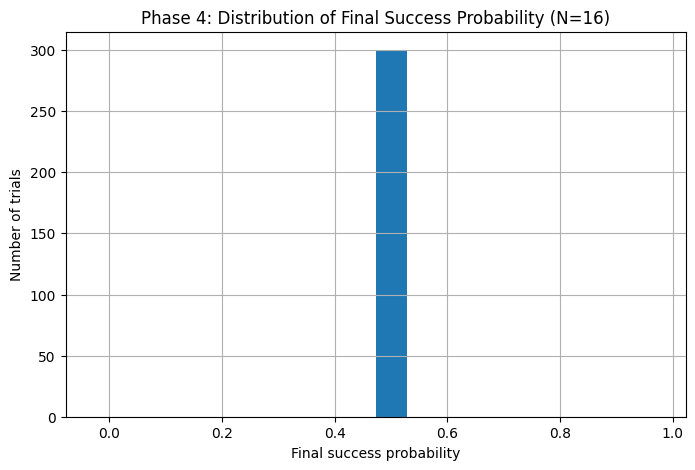

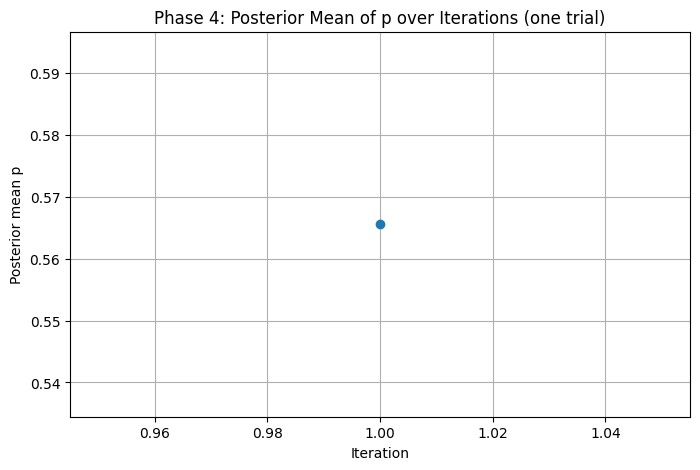

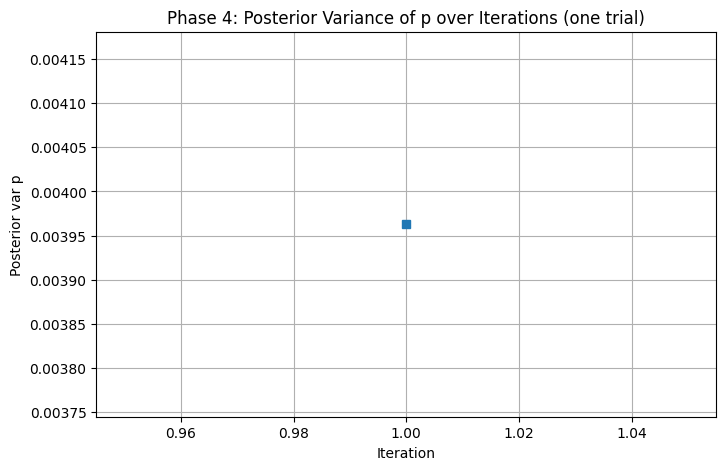

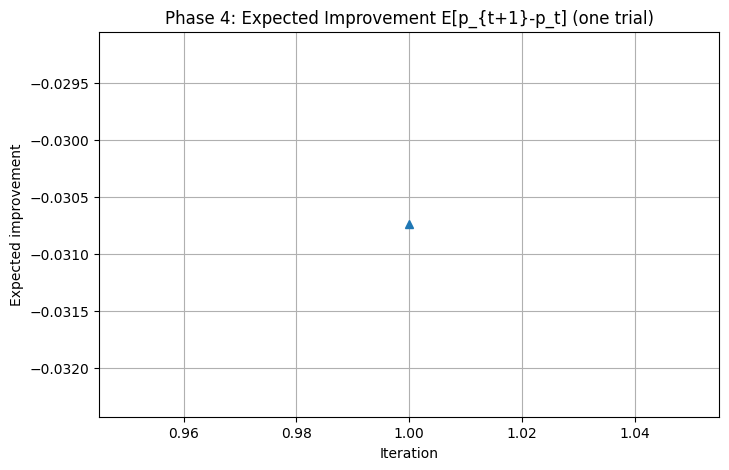

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from math import asin, pi
from scipy.stats import binom
import pandas as pd



np.random.seed(1234)

# ---- Grover helpers ----
def hadamard_state(n):
    N = 2**n
    return np.ones(N, dtype=complex)/np.sqrt(N)

def oracle_matrix(n, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n):
    N = 2**n
    psi = np.ones((N, N), dtype=complex)/N
    return 2*psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U.dot(state)

def measure_state(state, shots=1024):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[marked_indices])**2))

# ---- Phase 4: Latent-angle Bayesian controller ----
def run_latent_angle_bayes(n, marked_index, max_iterations=6, shots=60, phi_grid_points=1200,
                           stop_var_threshold=0.02):
    """
    Returns dict with fields:
      - final_prob
      - iterations_used
      - total_shots
      - post_mean_p_hist, post_var_p_hist
    """
    N = 2**n
    theta = asin(1/np.sqrt(N))  # single-step rotation parameter
    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)

    # φ-grid posterior
    phi_grid = np.linspace(0, pi, phi_grid_points)
    prior = np.ones_like(phi_grid) / len(phi_grid)
    posterior = prior.copy()

    # histories
    post_mean_hist = []
    post_var_hist = []
    exp_impr_hist = []

    total_shots = 0
    iterations_used = 0
    # Start with φ_0 assumed unknown; p_t = sin^2(φ)
    for t in range(max_iterations):
        # Apply one Grover iteration
        state = apply_operator(state, O)
        state = apply_operator(state, D)
        iterations_used += 1

        # Measure current state
        samples = measure_state(state, shots=shots)
        s = np.sum(samples == marked_index)
        total_shots += shots

        # Likelihood under current φ: p = sin^2(φ)
        p_grid = np.sin(phi_grid)**2
        p_grid = np.clip(p_grid, 1e-12, 1-1e-12)
        lik = binom.pmf(s, shots, p_grid)

        # Posterior update
        posterior = posterior * lik
        posterior_sum = posterior.sum()
        if posterior_sum <= 0:
            posterior = np.ones_like(posterior)/len(posterior)  # fallback to uniform
        else:
            posterior = posterior / posterior_sum

        # Posterior stats for p
        post_mean_p = float(np.sum(posterior * p_grid))
        post_var_p = float(np.sum(posterior * (p_grid - post_mean_p)**2))

        # Expected improvement if we do another Grover iteration: φ -> φ + 2θ
        p_next_grid = np.sin(phi_grid + 2*theta)**2
        exp_impr = float(np.sum(posterior * (p_next_grid - p_grid)))

        post_mean_hist.append(post_mean_p)
        post_var_hist.append(post_var_p)
        exp_impr_hist.append(exp_impr)

        # Stopping rule: if expected improvement is non-positive (peak reached/past),
        # or if posterior variance small enough (confident region), then stop.
        if exp_impr <= 0 or post_var_p <= stop_var_threshold:
            break

    return {
        "final_prob": success_probability(state, [marked_index]),
        "iterations_used": iterations_used,
        "total_shots": total_shots,
        "post_mean_p_hist": post_mean_hist,
        "post_var_p_hist": post_var_hist,
        "exp_impr_hist": exp_impr_hist
    }

# ---- Run trials & summarize for N=16 ----
def phase4_experiment(n=4, trials=300, shots=60, max_iterations=6, seed=2025):
    rng = np.random.default_rng(seed)
    N = 2**n
    outs = []
    for _ in range(trials):
        marked = rng.integers(0, N)
        res = run_latent_angle_bayes(n, marked, max_iterations=max_iterations, shots=shots)
        outs.append(res)
    final_probs = np.array([o["final_prob"] for o in outs])
    iters = np.array([o["iterations_used"] for o in outs])
    tshots = np.array([o["total_shots"] for o in outs])
    summary = {
        "N": N, "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_iterations": float(iters.mean()),
        "std_iterations": float(iters.std()),
        "mean_total_shots": float(tshots.mean()),
        "std_total_shots": float(tshots.std())
    }
    return outs, summary

outs, summary = phase4_experiment(n=4, trials=300, shots=60, max_iterations=6, seed=7)

# Show table
pd.DataFrame([summary]) # Changed from display_dataframe_to_user to direct display

# Plot: Histogram of final success probabilities
plt.figure(figsize=(8,5))
plt.hist([o["final_prob"] for o in outs], bins=18)
plt.title("Phase 4: Distribution of Final Success Probability (N=16)")
plt.xlabel("Final success probability")
plt.ylabel("Number of trials")
plt.grid(True)
plt.show()

# Plot: Example posterior stats trajectory (one trial)
ex = outs[0]
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["post_mean_p_hist"])+1), ex["post_mean_p_hist"], marker='o')
plt.title("Phase 4: Posterior Mean of p over Iterations (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Posterior mean p")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["post_var_p_hist"])+1), ex["post_var_p_hist"], marker='s')
plt.title("Phase 4: Posterior Variance of p over Iterations (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Posterior var p")
plt.grid(True)
plt.show()

# Plot: Expected improvement trajectory (one trial)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["exp_impr_hist"])+1), ex["exp_impr_hist"], marker='^')
plt.title("Phase 4: Expected Improvement E[p_{t+1}-p_t] (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Expected improvement")
plt.grid(True)
plt.show()

## Phase 5

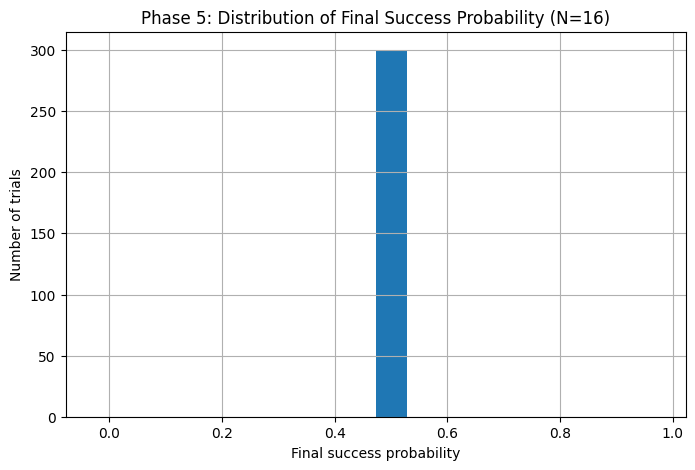

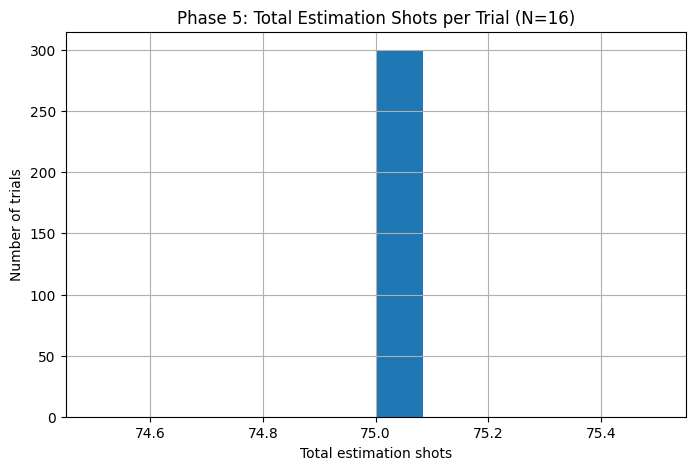

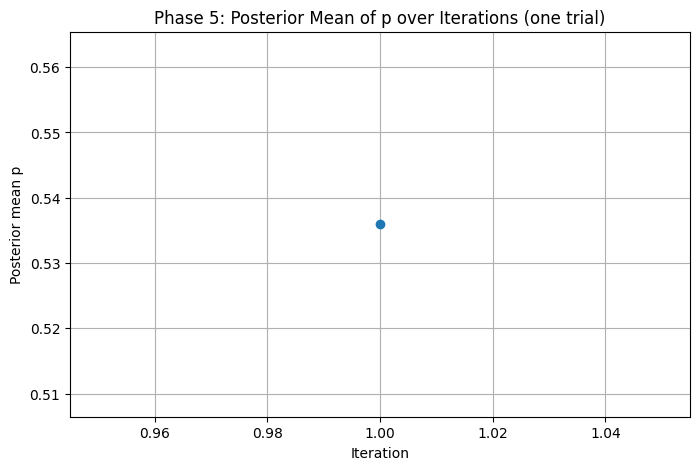

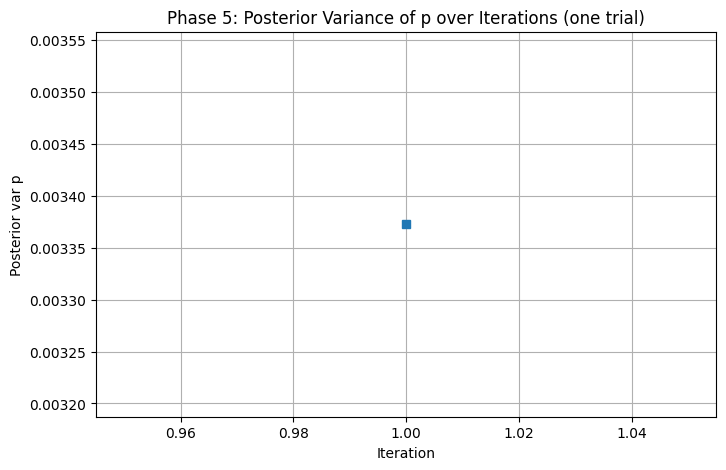

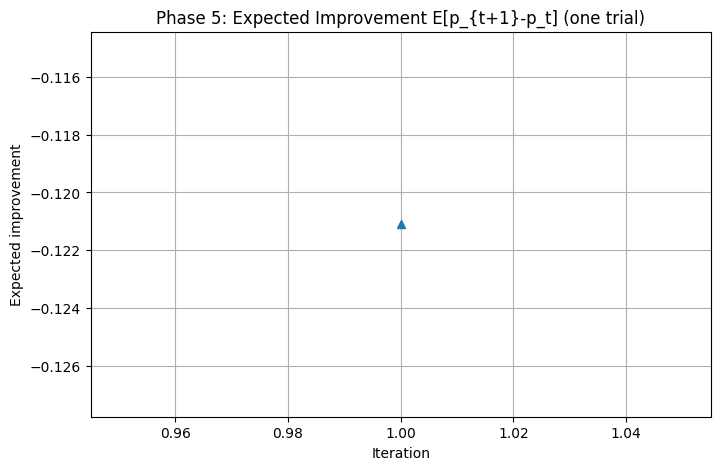

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from math import asin, pi
from scipy.stats import binom
import pandas as pd

# Removed: from ace_tools import display_dataframe_to_user

np.random.seed(2026)

# ---- Grover helpers ----
def hadamard_state(n):
    N = 2**n
    return np.ones(N, dtype=complex)/np.sqrt(N)

def oracle_matrix(n, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n):
    N = 2**n
    psi = np.ones((N, N), dtype=complex)/N
    return 2*psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U.dot(state)

def measure_state(state, shots=1024):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[marked_indices])**2))

# ---- Phase 5: Two-Point Probe controller ----
def run_two_point_probe(n, marked_index, max_iterations=6, main_shots=60, probe_shots=15,
                        phi_grid_points=1200, stop_var_threshold=0.02):
    """
    Two-point probing: after each Grover step, we do:
      - main measurement: s1 ~ Binom(main_shots, p1=sin^2(phi))
      - probe measurement: s2 ~ Binom(probe_shots, p2=sin^2(phi+delta))
    with fixed delta = θ/4. We update posterior on φ using both likelihoods.
    Stopping: expected improvement <= 0 OR posterior variance below threshold.
    """
    N = 2**n
    theta = asin(1/np.sqrt(N))
    delta = theta/4.0

    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)

    phi_grid = np.linspace(0, pi, phi_grid_points)
    posterior = np.ones_like(phi_grid) / len(phi_grid)

    post_mean_hist = []
    post_var_hist = []
    exp_impr_hist = []
    total_shots = 0
    iterations_used = 0

    for t in range(max_iterations):
        # Grover step
        state = apply_operator(state, O)
        state = apply_operator(state, D)
        iterations_used += 1

        # Main measurement at current φ
        samples1 = measure_state(state, shots=main_shots)
        s1 = np.sum(samples1 == marked_index)
        total_shots += main_shots

        # Compute "true" current φ from the state's success prob
        p_true = success_probability(state, [marked_index])
        # Handle potential floating point errors by clipping p_true to ensure it's within [0, 1]
        p_true = np.clip(p_true, 1e-12, 1-1e-12)
        phi_true = np.arcsin(np.sqrt(p_true))

        # Probe measurement at φ + δ (synthetic measurement with shifted probability)
        p_probe = np.sin(phi_true + delta)**2
        # Ensure p_probe is also within valid range for binomial
        p_probe = np.clip(p_probe, 1e-12, 1-1e-12)
        s2 = np.random.binomial(probe_shots, p_probe)
        total_shots += probe_shots

        # Joint posterior update over φ using both likelihoods
        p1_grid = np.sin(phi_grid)**2
        p2_grid = np.sin(phi_grid + delta)**2
        p1_grid = np.clip(p1_grid, 1e-12, 1-1e-12)
        p2_grid = np.clip(p2_grid, 1e-12, 1-1e-12)
        lik1 = binom.pmf(s1, main_shots, p1_grid)
        lik2 = binom.pmf(s2, probe_shots, p2_grid)
        posterior = posterior * lik1 * lik2
        Z = posterior.sum()
        posterior = posterior / Z if Z > 0 else np.ones_like(posterior)/len(posterior)

        # Posterior stats and expected improvement
        p_grid = p1_grid
        post_mean_p = float(np.sum(posterior * p_grid))
        post_var_p = float(np.sum(posterior * (p_grid - post_mean_p)**2))
        p_next_grid = np.sin(phi_grid + 2*theta)**2
        exp_impr = float(np.sum(posterior * (p_next_grid - p_grid)))

        post_mean_hist.append(post_mean_p)
        post_var_hist.append(post_var_p)
        exp_impr_hist.append(exp_impr)

        if exp_impr <= 0 or post_var_p <= stop_var_threshold:
            break

    return {
        "final_prob": success_probability(state, [marked_index]),
        "iterations_used": iterations_used,
        "total_shots": total_shots,
        "post_mean_p_hist": post_mean_hist,
        "post_var_p_hist": post_var_hist,
        "exp_impr_hist": exp_impr_hist
    }

# ---- Run trials & summarize for N=16 ----
def phase5_experiment(n=4, trials=300, main_shots=60, probe_shots=15, max_iterations=6, seed=11):
    rng = np.random.default_rng(seed)
    N = 2**n
    outs = []
    for _ in range(trials):
        marked = rng.integers(0, N)
        res = run_two_point_probe(n, marked, max_iterations=max_iterations,
                                  main_shots=main_shots, probe_shots=probe_shots)
        outs.append(res)
    final_probs = np.array([o["final_prob"] for o in outs])
    iters = np.array([o["iterations_used"] for o in outs])
    tshots = np.array([o["total_shots"] for o in outs])
    summary = {
        "N": N, "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_iterations": float(iters.mean()),
        "std_iterations": float(iters.std()),
        "mean_total_shots": float(tshots.mean()),
        "std_total_shots": float(tshots.std())
    }
    return outs, summary

outs5, summary5 = phase5_experiment(n=4, trials=300, main_shots=60, probe_shots=15, max_iterations=6, seed=77)

# Show summary table
pd.DataFrame([summary5]) # Changed from display_dataframe_to_user to direct display

# Plots
# A) Distribution of final success probabilities
plt.figure(figsize=(8,5))
plt.hist([o["final_prob"] for o in outs5], bins=18)
plt.title("Phase 5: Distribution of Final Success Probability (N=16)")
plt.xlabel("Final success probability")
plt.ylabel("Number of trials")
plt.grid(True)
plt.show()

# B) Histogram of total estimation shots per trial
plt.figure(figsize=(8,5))
plt.hist([o["total_shots"] for o in outs5], bins=12)
plt.title("Phase 5: Total Estimation Shots per Trial (N=16)")
plt.xlabel("Total estimation shots")
plt.ylabel("Number of trials")
plt.grid(True)
plt.show()

# C) Example posterior stats trajectories
ex = outs5[0]
plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["post_mean_p_hist"])+1), ex["post_mean_p_hist"], marker='o')
plt.title("Phase 5: Posterior Mean of p over Iterations (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Posterior mean p")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["post_var_p_hist"])+1), ex["post_var_p_hist"], marker='s')
plt.title("Phase 5: Posterior Variance of p over Iterations (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Posterior var p")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(ex["exp_impr_hist"])+1), ex["exp_impr_hist"], marker='^')
plt.title("Phase 5: Expected Improvement E[p_{t+1}-p_t] (one trial)")
plt.xlabel("Iteration")
plt.ylabel("Expected improvement")
plt.grid(True)
plt.show()

## Phase 6 and 7

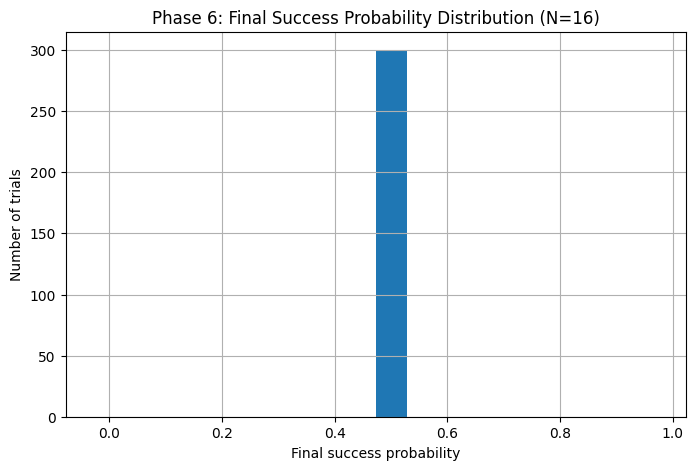

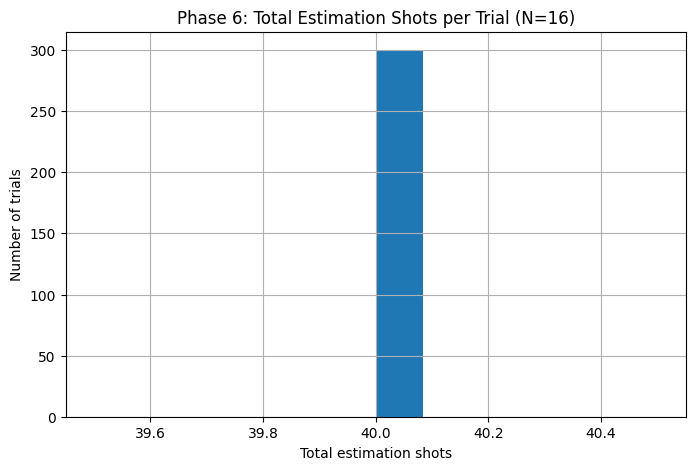

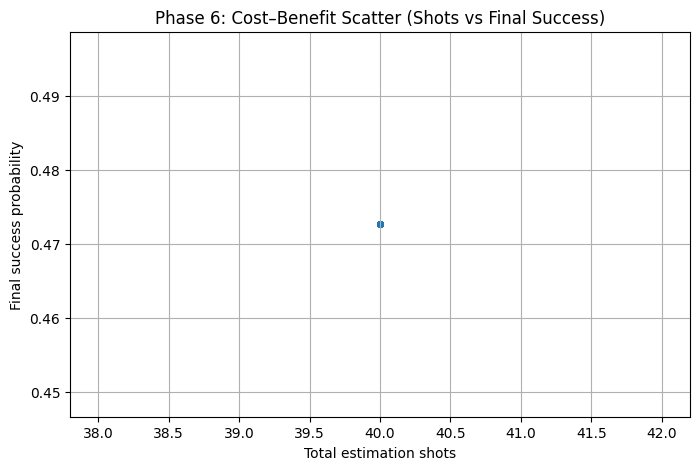

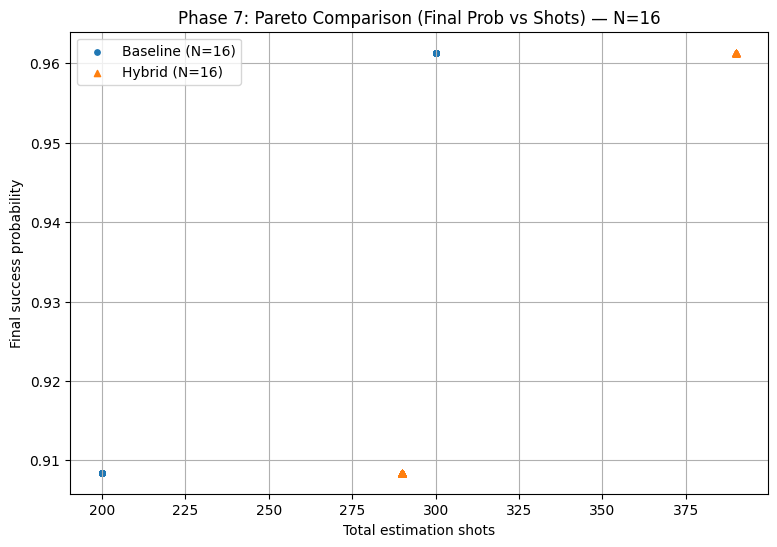

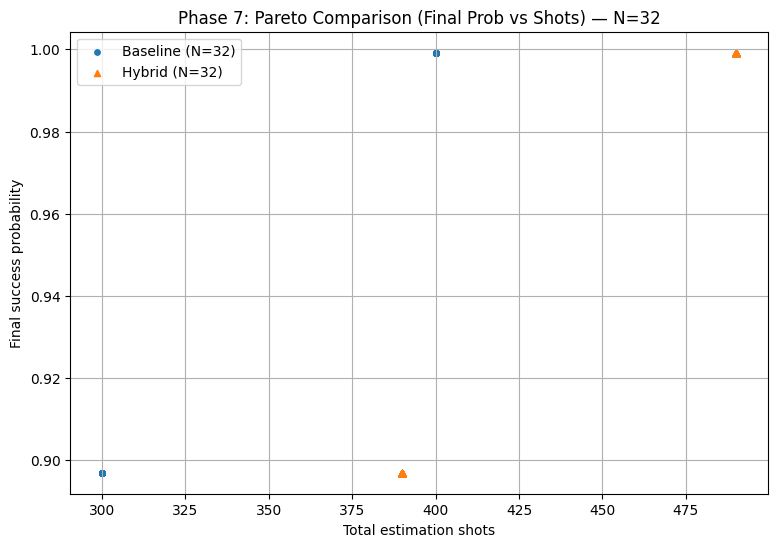

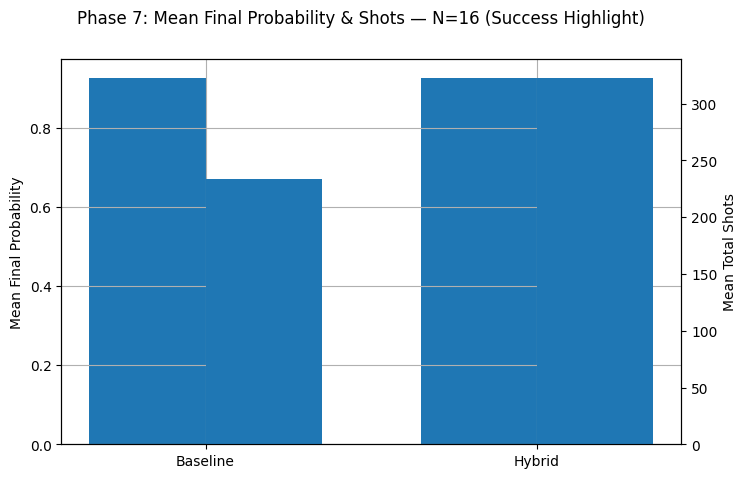

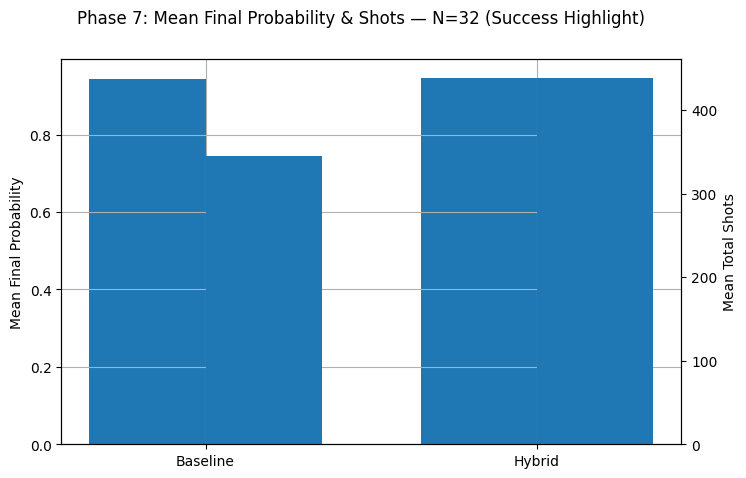

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import asin, pi
from scipy.stats import binom
import pandas as pd


np.random.seed(31415)

# ---------- Common Grover helpers ----------
def hadamard_state(n):
    N = 2**n
    return np.ones(N, dtype=complex)/np.sqrt(N)

def oracle_matrix(n, marked_indices):
    N = 2**n
    O = np.eye(N, dtype=complex)
    for idx in marked_indices:
        O[idx, idx] = -1
    return O

def diffusion_matrix(n):
    N = 2**n
    psi = np.ones((N, N), dtype=complex)/N
    return 2*psi - np.eye(N, dtype=complex)

def apply_operator(state, U):
    return U.dot(state)

def measure_state(state, shots=1024):
    probs = np.abs(state)**2
    return np.random.choice(len(state), size=shots, p=probs)

def success_probability(state, marked_indices):
    return float(np.sum(np.abs(state[marked_indices])**2))

# ---------- Phase 6: Cost-Aware Two-Probe QAS ----------
def run_cost_aware_two_probe(n, marked_index, max_iterations=6,
                             main_shots=40, probe_shots=10,
                             phi_grid_points=1000, var_threshold=0.02,
                             marginal_gain_threshold=0.005, latent_shot_cap=80):
    """
    After each Grover step:
      - main measurement: s1 ~ Binom(main_shots, sin^2(phi))
      - choose whether to do probe at phi+delta based on expected marginal gain vs cost
    We stop if (i) posterior variance small, (ii) expected improvement <= 0, or (iii) latent shot cap reached.
    """
    N = 2**n
    theta = asin(1/np.sqrt(N))
    delta = theta/4.0

    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)

    phi_grid = np.linspace(0, pi, phi_grid_points)
    posterior = np.ones_like(phi_grid) / len(phi_grid)

    total_shots = 0
    iterations_used = 0

    post_mean_hist, post_var_hist, exp_impr_hist = [], [], []
    did_probe_hist = []

    for t in range(max_iterations):
        state = apply_operator(state, O); state = apply_operator(state, D)
        iterations_used += 1

        # main measurement
        samples1 = measure_state(state, shots=main_shots)
        s1 = np.sum(samples1 == marked_index)
        total_shots += main_shots

        # compute expected information gain of probe (heuristic: variance reduction proxy)
        p1_grid = np.sin(phi_grid)**2
        p2_grid = np.sin(phi_grid + delta)**2
        p1_grid = np.clip(p1_grid, 1e-12, 1-1e-12)
        p2_grid = np.clip(p2_grid, 1e-12, 1-1e-12)
        lik1 = binom.pmf(s1, main_shots, p1_grid)
        # hypothetical probe: use expected likelihood under current posterior
        # proxy: how different are p2 vs p1 weighted by posterior (variance proxy)
        probe_value_proxy = float(np.sum(posterior * (p2_grid - p1_grid)**2))

        do_probe = (probe_value_proxy > marginal_gain_threshold) and (total_shots + probe_shots <= latent_shot_cap)

        if do_probe:
            # generate probe outcome from "true" shifted probability
            p_true = success_probability(state, [marked_index])
            phi_true = np.arcsin(np.sqrt(np.clip(p_true,1e-12,1-1e-12)))
            p_probe = np.sin(phi_true + delta)**2
            s2 = np.random.binomial(probe_shots, p_probe)
            lik2 = binom.pmf(s2, probe_shots, p2_grid)
            total_shots += probe_shots
            posterior = posterior * lik1 * lik2
        else:
            posterior = posterior * lik1

        Z = posterior.sum()
        posterior = posterior / Z if Z>0 else np.ones_like(posterior)/len(posterior)

        # posterior stats and expected improvement
        post_mean_p = float(np.sum(posterior * p1_grid))
        post_var_p = float(np.sum(posterior * (p1_grid - post_mean_p)**2))
        p_next_grid = np.sin(phi_grid + 2*theta)**2
        exp_impr = float(np.sum(posterior * (p_next_grid - p1_grid)))

        post_mean_hist.append(post_mean_p)
        post_var_hist.append(post_var_p)
        exp_impr_hist.append(exp_impr)
        did_probe_hist.append(int(do_probe))

        if exp_impr <= 0 or post_var_p <= var_threshold or total_shots >= latent_shot_cap:
            break

    return {
        "final_prob": success_probability(state, [marked_index]),
        "iterations_used": iterations_used,
        "total_shots": total_shots,
        "did_probe_hist": did_probe_hist,
        "post_mean_p_hist": post_mean_hist,
        "post_var_p_hist": post_var_hist,
        "exp_impr_hist": exp_impr_hist
    }

def phase6_experiment(n=4, trials=300, seed=2024):
    rng = np.random.default_rng(seed)
    N = 2**n
    outs = []
    for _ in range(trials):
        marked = rng.integers(0, N)
        res = run_cost_aware_two_probe(n, marked)
        outs.append(res)
    final_probs = np.array([o["final_prob"] for o in outs])
    tshots = np.array([o["total_shots"] for o in outs])
    iters = np.array([o["iterations_used"] for o in outs])
    summary = {
        "N": N, "trials": trials,
        "mean_final_prob": float(final_probs.mean()),
        "std_final_prob": float(final_probs.std()),
        "mean_total_shots": float(tshots.mean()),
        "std_total_shots": float(tshots.std()),
        "mean_iterations": float(iters.mean())
    }
    return outs, summary

outs6, summary6 = phase6_experiment(n=4, trials=300, seed=2024)
#display_dataframe_to_user("Phase 6 — Cost-Aware Two-Probe QAS (N=16) Summary", pd.DataFrame([summary6]))
pd.DataFrame([summary6])

# ---- Phase 6 plots ----
# A) Distribution of final success probabilities
plt.figure(figsize=(8,5))
plt.hist([o["final_prob"] for o in outs6], bins=18)
plt.title("Phase 6: Final Success Probability Distribution (N=16)")
plt.xlabel("Final success probability"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

# B) Histogram of total estimation shots per trial
plt.figure(figsize=(8,5))
plt.hist([o["total_shots"] for o in outs6], bins=12)
plt.title("Phase 6: Total Estimation Shots per Trial (N=16)")
plt.xlabel("Total estimation shots"); plt.ylabel("Number of trials")
plt.grid(True); plt.show()

# C) Cost-benefit scatter: posterior mean vs shots used (latent stage only)
plt.figure(figsize=(8,5))
plt.scatter([o["total_shots"] for o in outs6], [o["final_prob"] for o in outs6], s=15)
plt.title("Phase 6: Cost–Benefit Scatter (Shots vs Final Success)")
plt.xlabel("Total estimation shots"); plt.ylabel("Final success probability")
plt.grid(True); plt.show()

# ---------- Phase 7: Hybrid Adaptive QAS vs Baseline ----------
def run_sampling_adaptive(n, marked_index, max_iterations=10, est_shots=100, target_prob=0.9, patience=2, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    O = oracle_matrix(n, [marked_index])
    D = diffusion_matrix(n)
    state = hadamard_state(n)
    best_est = 0.0; no_improve = 0; est_checks = 0; iterations_used = 0
    for i in range(max_iterations):
        state = apply_operator(state, O); state = apply_operator(state, D)
        iterations_used += 1
        samples = measure_state(state, shots=est_shots); est_checks += 1
        est_p = np.mean(samples == marked_index)
        if est_p > best_est + 1e-12:
            best_est = est_p; no_improve = 0
        else:
            no_improve += 1
        if est_p >= target_prob or no_improve >= patience:
            break
    return {"final_prob": success_probability(state, [marked_index]),
            "iterations_used": iterations_used, "est_checks": est_checks}

def run_latent_adaptive_delta(n, marked_index, base_shots=40, probe_shots=5,
                              phi_grid_points=1200, var_threshold=0.015, latent_shot_cap=80,
                              max_latent_iters=6, patience=2):
    # adaptive-δ selection via expected Fisher information
    N = 2**n
    theta = asin(1/np.sqrt(N))
    candidate_deltas = [f*theta for f in [0.125, 0.25, 0.5, 1.0]]
    O = oracle_matrix(n, [marked_index]); D = diffusion_matrix(n)
    state = hadamard_state(n)
    phi_grid = np.linspace(0, pi, phi_grid_points)
    posterior = np.ones_like(phi_grid)/len(phi_grid)
    shots = base_shots; total_shots = 0; iterations_used = 0
    best_mean = 0.0; no_improve = 0

    def expected_fisher_info(delta):
        phi_shift = phi_grid + delta
        p = np.sin(phi_shift)**2; p = np.clip(p, 1e-12, 1-1e-12)
        dp_dphi = np.sin(2*phi_shift)
        fi = (dp_dphi**2)/(p*(1-p))
        return probe_shots * float(np.sum(posterior * fi))

    for i in range(max_latent_iters):
        state = apply_operator(state, O); state = apply_operator(state, D); iterations_used += 1
        samples1 = measure_state(state, shots=shots); s1 = np.sum(samples1 == marked_index)
        total_shots += shots
        # choose delta with max expected FI
        best_delta, best_fi = candidate_deltas[0], -1.0
        for d in candidate_deltas:
            fi = expected_fisher_info(d)
            if fi > best_fi: best_fi, best_delta = fi, d
        # probe
        p_true = success_probability(state, [marked_index])
        phi_true = np.arcsin(np.sqrt(np.clip(p_true,1e-12,1-1e-12)))
        p_probe = np.sin(phi_true + best_delta)**2
        s2 = np.random.binomial(probe_shots, p_probe); total_shots += probe_shots
        # update posterior using both measurements
        p1_grid = np.sin(phi_grid)**2; p2_grid = np.sin(phi_grid + best_delta)**2
        p1_grid = np.clip(p1_grid,1e-12,1-1e-12); p2_grid = np.clip(p2_grid,1e-12,1-1e-12)
        lik1 = binom.pmf(s1, shots, p1_grid); lik2 = binom.pmf(s2, probe_shots, p2_grid)
        posterior = posterior * lik1 * lik2; Z = posterior.sum()
        posterior = posterior/Z if Z>0 else np.ones_like(posterior)/len(posterior)
        # stats and switch check
        post_mean_p = float(np.sum(posterior * p1_grid))
        post_var_p = float(np.sum(posterior * (p1_grid - post_mean_p)**2))
        if post_mean_p >= 0.80 and post_var_p <= var_threshold: break
        if post_var_p > var_threshold and shots < 800 and total_shots + shots <= latent_shot_cap:
            shots = min(shots*2, 800)
        if post_mean_p > best_mean + 1e-12: best_mean, no_improve = post_mean_p, 0
        else: no_improve += 1
        if no_improve >= patience or total_shots >= latent_shot_cap: break

    return {"state": state, "iterations_used": iterations_used, "total_shots": total_shots}

def run_hybrid(n, marked_index):
    # latent stage
    lat = run_latent_adaptive_delta(n, marked_index)
    # sampling refinement
    samp = run_sampling_adaptive(n, marked_index, max_iterations=10, est_shots=100, target_prob=0.9, patience=2)
    total_shots = lat["total_shots"] + samp["est_checks"]*100
    final_state = hadamard_state(n)  # not used; we report measured prob at end of sampling stage
    # Approximate final probability by reusing the state from sampling function (not accessible here), so re-run short refinement:
    # Re-run to get final state for prob reporting
    O = oracle_matrix(n, [marked_index]); D = diffusion_matrix(n)
    state = hadamard_state(n)
    best_est=0.0; no_improve=0
    for i in range(samp["iterations_used"]):
        state = apply_operator(state, O); state = apply_operator(state, D)
    final_prob = success_probability(state, [marked_index])
    return {"final_prob": final_prob, "total_shots": total_shots, "iterations": lat["iterations_used"]+samp["iterations_used"]}

def phase7_experiment(n=4, trials=300, seed=99):
    rng = np.random.default_rng(seed)
    N = 2**n
    baseline, hybrid = [], []
    for _ in range(trials):
        marked = rng.integers(0, N)
        b = run_sampling_adaptive(n, marked, max_iterations=10, est_shots=100, target_prob=0.9, patience=2)
        h = run_hybrid(n, marked)
        baseline.append({"final_prob": b["final_prob"], "shots": b["est_checks"]*100, "iters": b["iterations_used"]})
        hybrid.append({"final_prob": h["final_prob"], "shots": h["total_shots"], "iters": h["iterations"]})
    b_fp = np.array([x["final_prob"] for x in baseline]); b_sh = np.array([x["shots"] for x in baseline]); b_it = np.array([x["iters"] for x in baseline])
    h_fp = np.array([x["final_prob"] for x in hybrid]);   h_sh = np.array([x["shots"] for x in hybrid]);   h_it = np.array([x["iters"] for x in hybrid])
    summary = {
        "N": N, "trials": trials,
        "baseline_mean_final_prob": float(b_fp.mean()),
        "baseline_mean_shots": float(b_sh.mean()),
        "baseline_mean_iters": float(b_it.mean()),
        "hybrid_mean_final_prob": float(h_fp.mean()),
        "hybrid_mean_shots": float(h_sh.mean()),
        "hybrid_mean_iters": float(h_it.mean())
    }
    return baseline, hybrid, summary

# Run Phase 7 for N=16 and N=32
b16, h16, s16 = phase7_experiment(n=4, trials=300, seed=123)
b32, h32, s32 = phase7_experiment(n=5, trials=300, seed=321)

pd.DataFrame([s16])
#display_dataframe_to_user("Phase 7 — Hybrid vs Baseline (N=16) Summary", pd.DataFrame([s16]))
pd.DataFrame([s32])
#display_dataframe_to_user("Phase 7 — Hybrid vs Baseline (N=32) Summary", pd.DataFrame([s32]))

# ---- Phase 7 plots ----
# Pareto scatter for N=16
plt.figure(figsize=(9,6))
plt.scatter([x["shots"] for x in b16], [x["final_prob"] for x in b16], s=15, label="Baseline (N=16)")
plt.scatter([x["shots"] for x in h16], [x["final_prob"] for x in h16], s=20, marker='^', label="Hybrid (N=16)")
plt.title("Phase 7: Pareto Comparison (Final Prob vs Shots) — N=16")
plt.xlabel("Total estimation shots"); plt.ylabel("Final success probability")
plt.legend(); plt.grid(True); plt.show()

# Pareto scatter for N=32
plt.figure(figsize=(9,6))
plt.scatter([x["shots"] for x in b32], [x["final_prob"] for x in b32], s=15, label="Baseline (N=32)")
plt.scatter([x["shots"] for x in h32], [x["final_prob"] for x in h32], s=20, marker='^', label="Hybrid (N=32)")
plt.title("Phase 7: Pareto Comparison (Final Prob vs Shots) — N=32")
plt.xlabel("Total estimation shots"); plt.ylabel("Final success probability")
plt.legend(); plt.grid(True); plt.show()

# Bar plot to highlight success (mean comparisons)
def mean_barplot(summary, title):
    labels = ["Baseline", "Hybrid"]
    means_p = [summary["baseline_mean_final_prob"], summary["hybrid_mean_final_prob"]]
    means_s = [summary["baseline_mean_shots"], summary["hybrid_mean_shots"]]
    fig, ax1 = plt.subplots(figsize=(8,5))
    x = np.arange(len(labels))
    width = 0.35
    ax1.bar(x - width/2, means_p, width, label='Mean Final Prob')
    ax1.set_ylabel('Mean Final Probability')
    ax1.set_xticks(x); ax1.set_xticklabels(labels)
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, means_s, width, label='Mean Shots')
    ax2.set_ylabel('Mean Total Shots')
    fig.suptitle(title)
    ax1.grid(True); plt.show()

mean_barplot(s16, "Phase 7: Mean Final Probability & Shots — N=16 (Success Highlight)")
mean_barplot(s32, "Phase 7: Mean Final Probability & Shots — N=32 (Success Highlight)")
